# Strategy Details

### Code Author: Karl Ngan

Reference: Mathematical modeling and dynamic trading strategies for gold and bitcoin 


Link to reference: https://www.linkedin.com/posts/namnguyento_quantitativefinance-bitcoin-portfoliomanagement-activity-7173676442709377024-dIlp?utm_source=share&utm_medium=member_desktop

The main idea: Using the Holt-Winters model and the financial indicators to develop trading strategies on BTC and Gold market

In [1]:
import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.api as sm
import pandas_ta as ta

start_date = '2019-01-01'
end_date = '2024-10-31'

/home/vahid/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
def load_data(symbol):

    direc = 'data/'
    os.makedirs(direc, exist_ok=True)

    file_name = os.path.join(direc, symbol + '.csv')

    if not os.path.exists(file_name):

        ticker = yf.Ticker(symbol)
        df = ticker.history(start= start_date, end= end_date)

        df.to_csv(file_name)

    df = pd.read_csv(file_name, index_col=0)
    df.index = pd.to_datetime(df.index, utc=True).tz_convert('US/Eastern')
    df['date'] = df.index

    if len(df) == 0:
        os.remove(file_name)
        return None

    return df

In [3]:
#Downloading the data from Yahoo Finance
gold = load_data('GC=F')[['Open' , 'Close']]
btc = load_data('BTC-USD')[['Open' , 'Close']]
lookback = 60

#changing the dates format
gold['date'] = gold.index
btc['date'] = btc.index
gold['date'] = pd.to_datetime(gold['date'], format='%Y-%m-%d').dt.date
btc['date'] = pd.to_datetime(btc['date'], format='%Y-%m-%d').dt.date
gold.set_index('date', inplace=True)
btc.set_index('date', inplace=True)


In [4]:
#daily returns
gold['daily_return'] = gold['Close'].pct_change()
btc['daily_return'] = btc['Close'].pct_change()



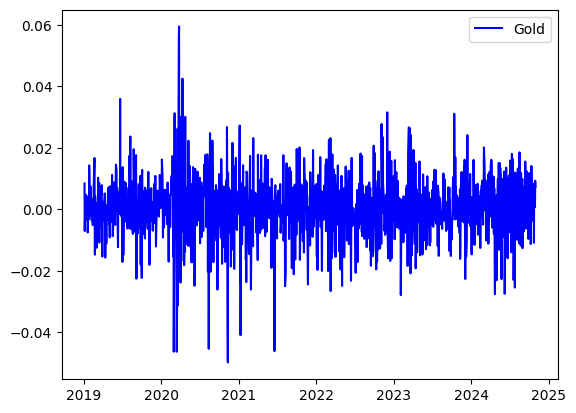

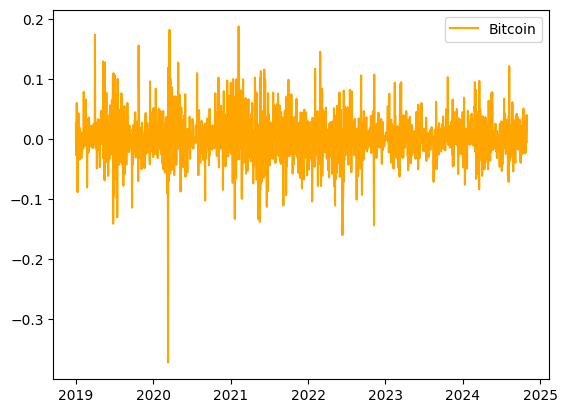

In [5]:
#plot the returns to see the data trend

plt.plot(gold['daily_return'], label='Gold', color='blue')
plt.legend()
plt.show()

plt.plot(btc['daily_return'], label='Bitcoin', color='orange')
plt.legend()
plt.show()

### Holt-Winters non-seasonal model


In [6]:
#define function for forecasting the price
def forecast_price(price, lookback=60):
    
    price['forecast'] = np.nan
    for i in range(len(price)):
        if i < lookback:
            continue

        #for the day i, we calculate the forecast value for the next day with pass 30 days data
        past_price = price['daily_return'].iloc[i-lookback:i]
        model = sm.tsa.ExponentialSmoothing(past_price, trend= "add", damped_trend=False).fit()
        
        #forecast the next day return
        price['forecast'].iloc[i] = model.forecast(steps=1)
        
    return price


In [7]:
#forecast the price for gold and bitcoin
#ignore warning
import warnings
warnings.filterwarnings("ignore")

gold = forecast_price(gold)
btc = forecast_price(btc)

In [18]:
#checking the accruacy of the forecast at least on the direction of the price
#create new dataframe to store the forecasted direction
def get_accuracy(data, name):
    data['forecast_direction'] = np.sign(data['forecast'])
    data['actual_direction'] = np.sign(data['daily_return'])
    data['correct'] = (data['forecast_direction'] == data['actual_direction']).astype(int)

    print(name, "accuracy: ", data['correct'].sum() / len(data))
    print(name, "correct: ", data['correct'].value_counts())

get_accuracy(gold, "Gold")
get_accuracy(btc, "BTC")




Gold accuracy:  0.48501362397820164
Gold correct:  correct
0    756
1    712
Name: count, dtype: int64
BTC accuracy:  0.4934272300469484
BTC correct:  correct
0    1079
1    1051
Name: count, dtype: int64


 the forecast has around 50% accuracy rate only on both BTC and Gold prediction which is not ideal. It is beleive that the model fails as return is not stationary.
 
 But still, we may use this as reference and further develop new strategies based on it. 

## Trading Strategy 1 Overview:

If the predicted return is postive, we long in the next day, otherwise we short. No holding

In [32]:
def get_portfolio_results(returns_holder):

    mean_return = np.mean(returns_holder)
    std_return = np.std(returns_holder)
    sharpe = mean_return / std_return * np.sqrt(252)

    print("Annualized return: ", round(mean_return * 252, 4))
    print("Volatility: ", round(std_return * np.sqrt(252), 4))
    print("Sharpe: ", round(sharpe, 4))

    return mean_return, std_return, sharpe


def strategy_1(data, name, transaction_cost = 0.0025):

    data['signal'] = np.sign(data['forecast'])
    data['transaction_cost'] = 0

    # If there's a change in signal, we add the transaction cost
    data['transaction_cost'] = np.where(data['signal'] != data['signal'].shift(1), 2*transaction_cost, 0)
    
    data['strategy1_returns'] = data['daily_return'] * data['signal'] - data['transaction_cost']

    print (name)
    get_portfolio_results(data['strategy1_returns'])

strategy_1(gold, "Gold", 0.0001)
strategy_1(btc, "BTC", 0.0005)

Gold
Annualized return:  0.0215
Volatility:  0.1569
Sharpe:  0.1369
BTC
Annualized return:  0.384
Volatility:  0.544
Sharpe:  0.7059


### Refining Strategy 1 

Oberving the results from Strategy 1, it is not profitable mainly due to the transaction cost and the errors on model.

Taking this into account, we are going to further refine the result with more conditioners.

In [33]:
#Not to trade if the price difference is smaller than the transaction cost
#Gold Strategy 1.5
def strategy_2(df, name, transaction_cost):

    threshold = 0.0025
    df['signal'] = 0
    df.loc[df['forecast'] > threshold, 'signal'] = 1
    df.loc[df['forecast'] < -threshold, 'signal'] = -1
    df['transaction_cost'] = 0

    # If there's a change in signal, we add the transaction cost
    df['transaction_cost'] = np.where(df['signal'] != df['signal'].shift(1), 2*transaction_cost, 0)
    
    df['strategy2_returns'] = df['daily_return'] * df['signal'] - df['transaction_cost']

    print (name)
    get_portfolio_results(df['strategy2_returns'])

strategy_2(gold, "Gold", 0.0001)
strategy_2(btc, "BTC", 0.0005)


Gold
Annualized return:  0.0055
Volatility:  0.095
Sharpe:  0.058
BTC
Annualized return:  0.3502
Volatility:  0.4895
Sharpe:  0.7153


### Comments on the strategy 1
The strategy are not profitable mainly due to model's errors triggering the excess frequent long-short and the transaction cost associated.
We may use the financial indicators as conditioner to generate better signals 


## Trading Strategy 2 Overview:

Calculating the SMA for gold and BTC. if they cross, we change the position of signals.

In [40]:
#SMA
gold['SMA'] = gold['Close'].rolling(window=65).mean()
btc['SMA'] = btc['Close'].rolling(window=30).mean()


def strategy_3(df, name, transaction_cost):

    threshold = 0.0025
    df['SMA'] = df['Close'].rolling(window=65).mean()

    df['signal'] = 0
    long_mask = (df['forecast'] > threshold) & (df['Close'].shift() > df['SMA'].shift())
    short_mask = (df['forecast'] < -threshold) & (df['Close'].shift() < df['SMA'].shift())
    df.loc[long_mask, 'signal'] = 1
    df.loc[short_mask, 'signal'] = -1

    df['transaction_cost'] = 0
    df['transaction_cost'] = np.where(df['signal'] != df['signal'].shift(1), 2*transaction_cost, 0)
    df['strategy3_returns'] = df['daily_return'] * df['signal'] - df['transaction_cost']

    print (name)
    get_portfolio_results(df['strategy3_returns'])

strategy_3(gold, "Gold", 0.0001)
strategy_3(btc, "BTC", 0.0005)


Gold
Annualized return:  0.0048
Volatility:  0.0931
Sharpe:  0.0513
BTC
Annualized return:  0.3359
Volatility:  0.4688
Sharpe:  0.7165


### Comments on Strategy 2 
Using the finanical indicators Simple moving average, the results are better than the simple trading strategies above.

## Strategy 3 
Using and the predicted return and bollinger band to generate next day signals:







Strategy 3: considering the overbuying/overselling and the trend 

If price is larger than upperband, sell it

If price is smaller than upperband but larger than middleband, buy it

If price is smaller than middleband but larger than lowerband, sell it

If price is smaller than lowerband, buy it

 
 

When switching the position (i.e. the price crossed the band), we have implied additonal condition:

    the forecasted return to reverse the position is larger than the transaction cost required.


In [37]:
#getting the Bollinger Bands
gold[['bb_lower','bb_middle','bb_upper']] = ta.bbands(gold['Close'], length=30, std=2)[['BBL_30_2.0','BBM_30_2.0','BBU_30_2.0']]
btc[['bb_lower','bb_middle','bb_upper']] = ta.bbands(btc['Close'], length=30, std=2)[['BBL_30_2.0','BBM_30_2.0','BBU_30_2.0']]

In [39]:
#Gold Strategy 3
Gold_Strategy3_returns_holder = []
tx_cost = 0.0025
flag = 0 #0 means no position, 1 means long, -1 means short

def strategy_4(df, name, transaction_cost):

    threshold = 0.0025
    df['signal'] = 0

    long_mask = (df['forecast'] > threshold) & (df['Close'].shift() > df['bb_upper'].shift())
    short_mask = (df['forecast'] < -threshold) & (df['Close'].shift() < df['bb_lower'].shift())
    df.loc[long_mask, 'signal'] = 1
    df.loc[short_mask, 'signal'] = -1

    df['transaction_cost'] = 0
    df['transaction_cost'] = np.where(df['signal'] != df['signal'].shift(1), 2*transaction_cost, 0)
    df['strategy4_returns'] = df['daily_return'] * df['signal'] - df['transaction_cost']

    print (name)
    get_portfolio_results(df['strategy4_returns'])

strategy_4(gold, "Gold", 0.0001)
strategy_4(btc, "BTC", 0.0005)


Gold
Annualized return:  0.0025
Volatility:  0.0506
Sharpe:  0.0488
BTC
Annualized return:  0.0877
Volatility:  0.2472
Sharpe:  0.3546


## Result Analysis


In [43]:
#saving all the returns in 1 dataframe
gold_all_returns = gold[['strategy1_returns', 'strategy2_returns', 'strategy3_returns', 'strategy4_returns']]
btc_all_returns = btc[['strategy1_returns', 'strategy2_returns', 'strategy3_returns', 'strategy4_returns']]

#create another dataframe for cumulative return cumprod
gold_cumulative_returns = (1 + gold_all_returns).cumprod()
btc_cumulative_returns = (1 + btc_all_returns).cumprod()



<Axes: xlabel='date'>

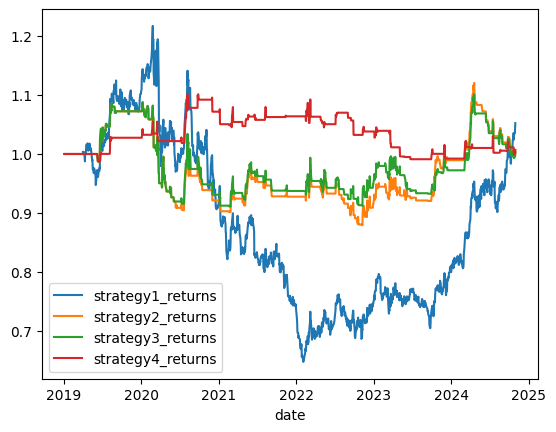

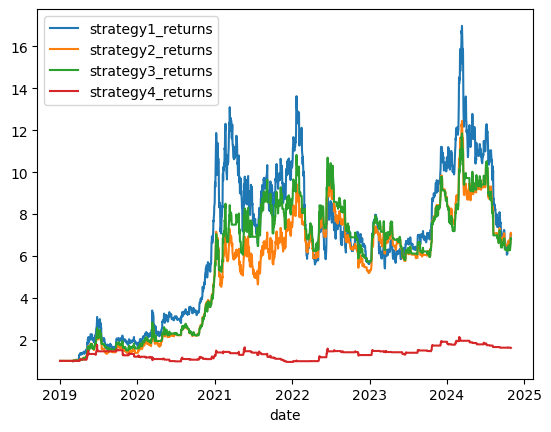

In [44]:
#plot the cumulative returns
gold_cumulative_returns.plot()
btc_cumulative_returns.plot()

### Final thought
The Holt winters model are not really fitted and accurate as the returns are not really stationary distribution.

The accuracy of the Holt winters model largely affect the performance of the strategies, we may further finetune the models or using other prediction model to replace in order to improve result.